In [1]:
import time

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.utils import check_random_state

from dataset import generate_synthetic_data, calc_true_value
from estimators import calc_avg, calc_tis, calc_sis, calc_dr, calc_mis
from policy import eps_greedy_policy
from utils import softmax


In [2]:
px = np.array([0.5, 0.5])
pi = np.array([[0.8, 0.2], [0.2, 0.8]])
pi1 = np.array([[0.2, 0.8], [0.8, 0.2]])
pi2 = np.array([[0.9, 0.1], [0.1, 0.9]])
pib = (pi1 + pi2) / 2
q = np.array([[10, 1], [1, 10]])

In [3]:
v1 = (px * pi1 * (q * pi / pi1) ** 2).sum() - (px * pi1 * (q * pi / pi1)).sum() ** 2
v2 = (px * pi2 * (q * pi / pi2) ** 2).sum() - (px * pi2 * (q * pi / pi2)).sum() ** 2
print((v1 + v2) / 4, v2)

64.27027777777778 4.271111111111139


In [13]:
v1b = (px * pi1 * (q * pi / pib) ** 2).sum() - (px * pi1 * (q * pi / pib)).sum() ** 2
v2b = (px * pi2 * (q * pi / pib) ** 2).sum() - (px * pi2 * (q * pi / pib)).sum() ** 2
print((v1b + v2b) / 4, v2)

12.427405366799306 4.271111111111139


In [14]:
print((0.02 ** 2) * v1 + (0.98 ** 2) * v2)

4.203099111111138


## データ数を変化させる

In [13]:
## 実験設定

num_runs = 200 # number of experiment runs
dim_state = 5 # state dimensions
num_states = 50 # number of states
num_actions = 10 # number of unique actions
H = 6 # length of horizon
beta = -3 # parameter of the logging policy
random_state = 12345
num_data_list = [250, 500, 1000, 2000, 4000]


In [14]:
# calculate the ground-truth value of a new policy, our estimand
random_ = check_random_state(random_state)
theta = random_.normal(size=(dim_state, num_actions))
M = random_.normal(size=(dim_state, num_actions))
b = random_.normal(size=(1, num_actions))
init_dist = softmax(random_.normal(size=(1, num_states)))[0]
trans_probs = softmax(random_.normal(size=(num_states, num_states, num_actions)) / 2)
dataset_test, policy_value = calc_true_value(
    dim_state=dim_state, num_states=num_states, num_actions=num_actions, H=H,
    theta=theta, M=M, b=b, init_dist=init_dist, trans_probs=trans_probs,
)

result_df_list = []
for num_data in num_data_list:
    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## generate synthetic logged bandit data
        dataset = generate_synthetic_data(
            num_data=num_data, dim_state=dim_state, num_states=num_states, num_actions=num_actions, H=H,
            theta=theta, M=M, b=b, init_dist=init_dist, trans_probs=trans_probs, beta=beta, random_state=_,
        )

        ## perform OPE on the logged bandit data
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_avg(dataset)
        estimated_policy_values["tis"] = calc_tis(dataset)
        estimated_policy_values["sis"] = calc_sis(dataset)
        Q_hat = dataset["q_s_a"] + random_.normal(size=(num_states, num_actions))
        estimated_policy_values["dr"] = calc_dr(dataset, Q_hat)
        estimated_policy_values["mis"] = calc_mis(dataset, dataset_test)
        estimated_policy_value_list.append(estimated_policy_values)

        ### calculate the MSE, squared bias, and variance of estimators
        result_df = DataFrame(estimated_policy_value_list).stack()\
            .reset_index(1).rename(columns={"level_1": "est", 0: "value"})
        result_df["num_data"] = num_data
        result_df["se"] = (result_df.value - policy_value) ** 2
        result_df["bias"] = 0
        result_df["variance"] = 0
        result_df["true_value"] = policy_value
        sample_mean = DataFrame(result_df.groupby(["est"]).mean().value).reset_index()
        for est_ in sample_mean["est"]:
            estimates = result_df.loc[result_df["est"] == est_, "value"].values
            mean_estimates = sample_mean.loc[sample_mean["est"] == est_, "value"].values
            mean_estimates = np.ones_like(estimates) * mean_estimates
            result_df.loc[result_df["est"] == est_, "bias"] = (policy_value - mean_estimates) ** 2
            result_df.loc[result_df["est"] == est_, "variance"] = (estimates - mean_estimates) ** 2
    result_df_list.append(result_df)
result_df_data = pd.concat(result_df_list).reset_index(level=0)


num_data=4000...: 100%|██████████| 200/200 [01:42<00:00,  1.95it/s]


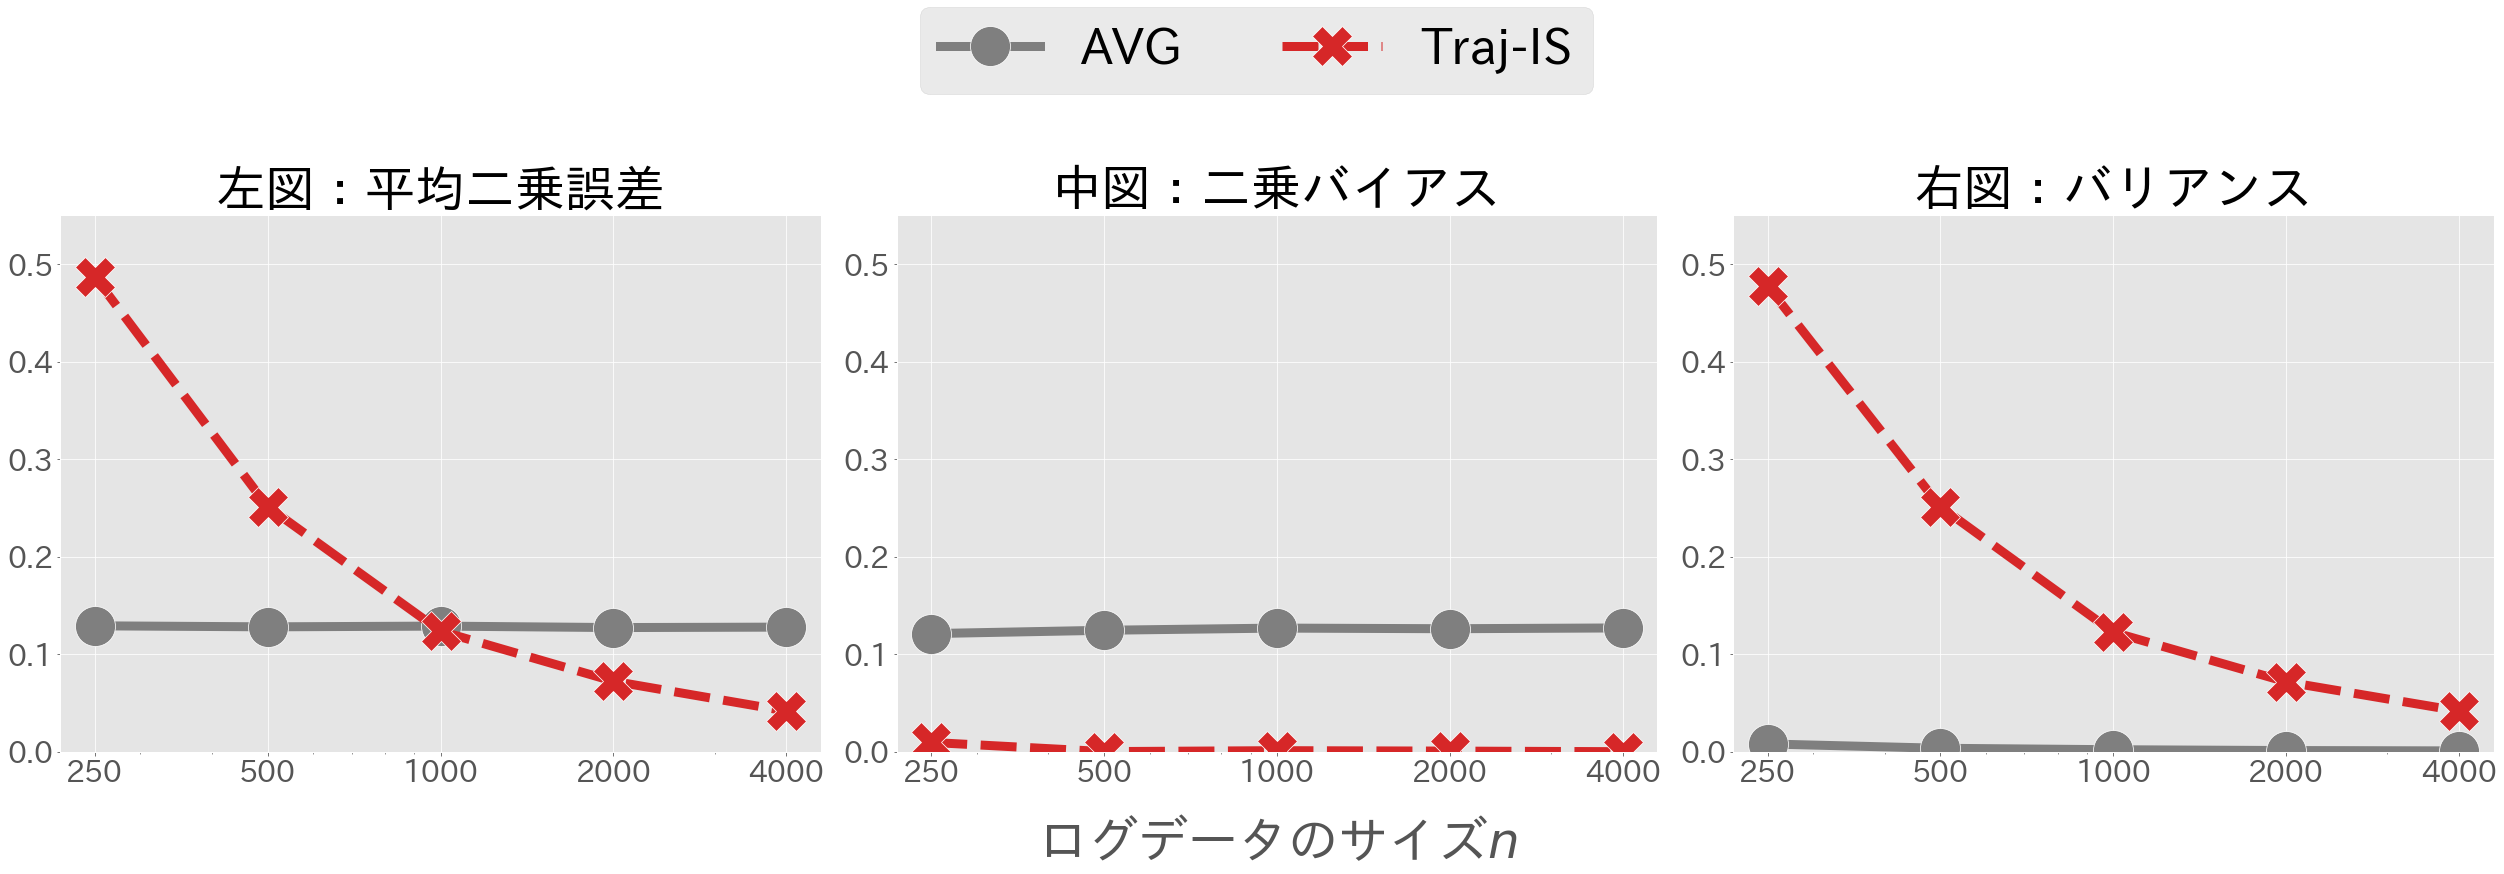

In [15]:
plt.style.use('ggplot')
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red"],
        data=result_df_data.query("est == 'avg' or est == 'tis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.55)
    ax.tick_params(axis="y", labelsize=30)
    # ax.set_yticks([0.0, 0.35, 0.7])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["AVG", "Traj-IS"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15),
    ncol=5, loc="center",
)


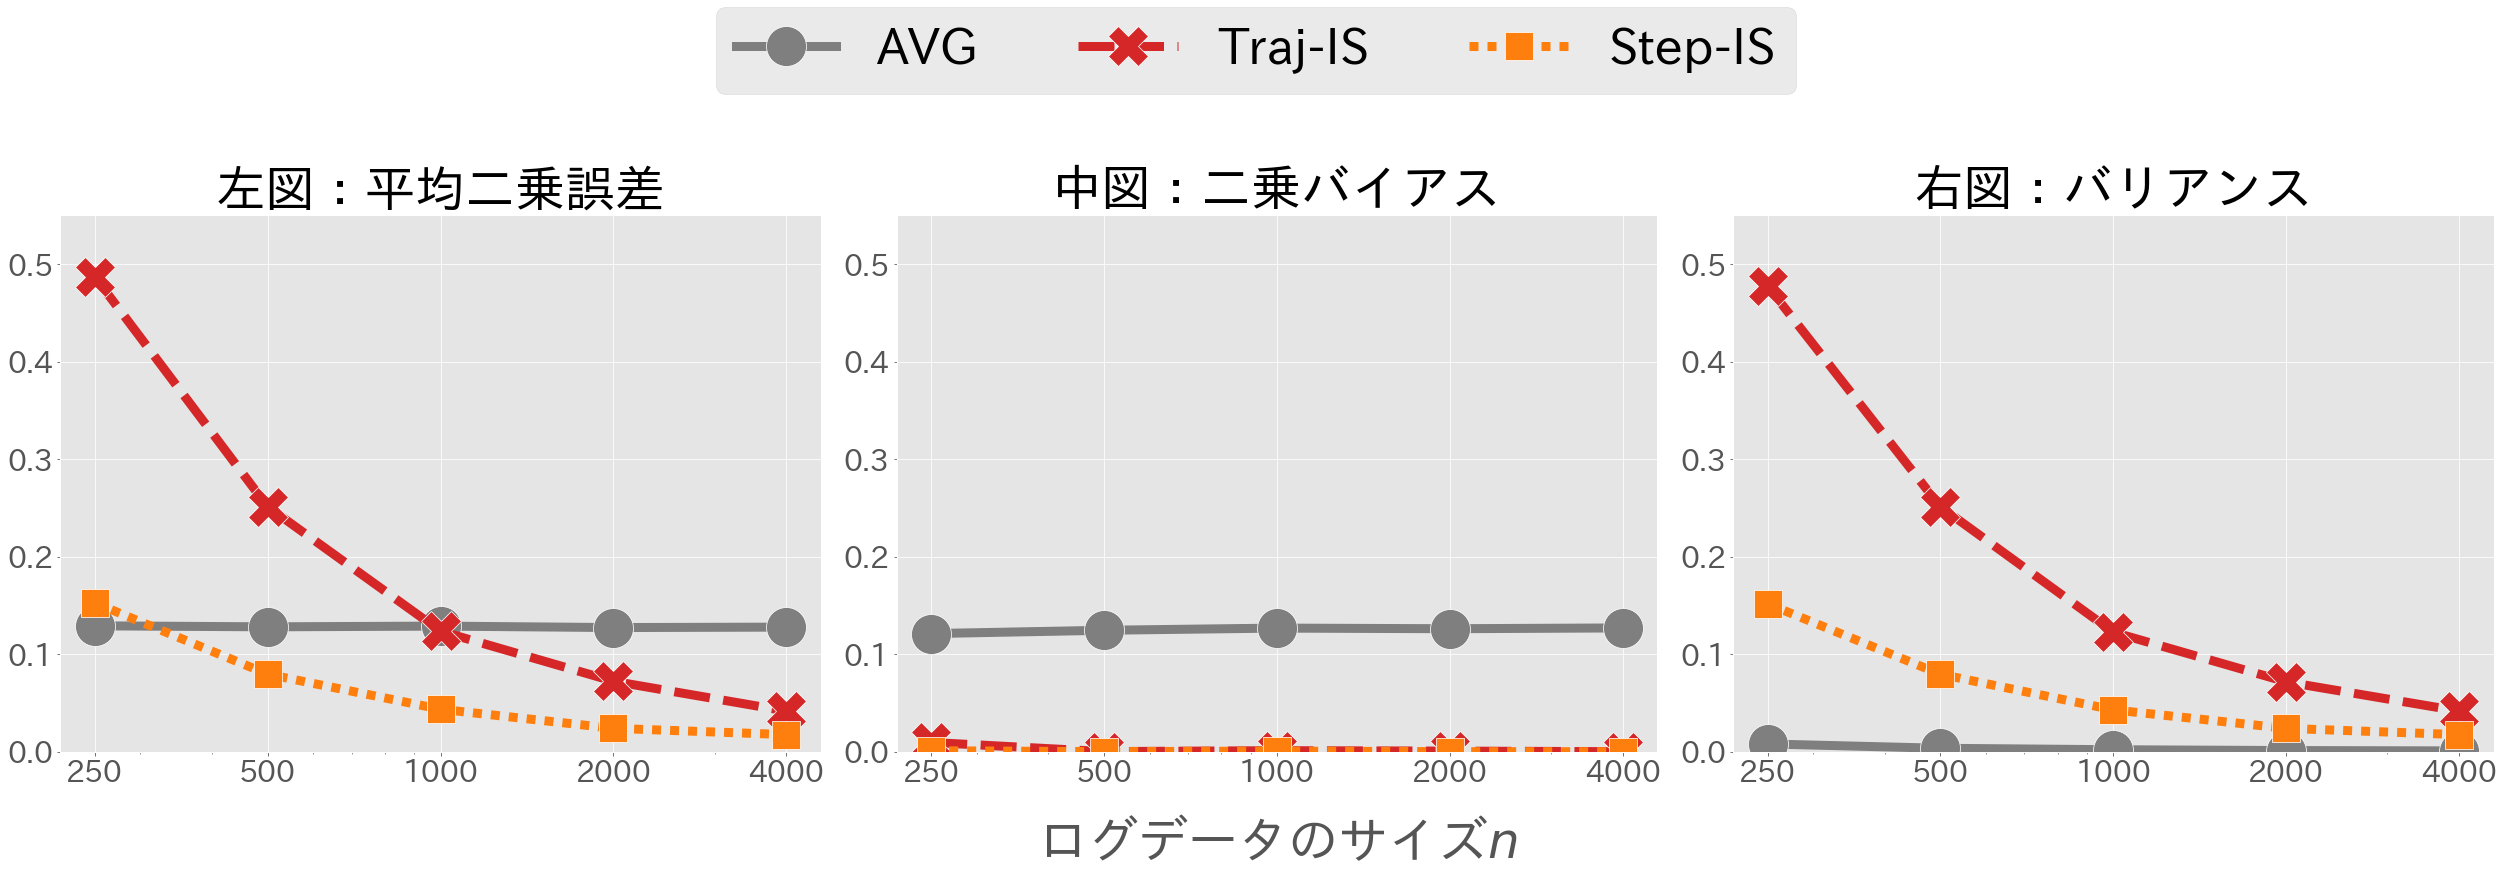

In [16]:
plt.style.use('ggplot')
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red", "tab:orange"],
        data=result_df_data.query("est == 'avg' or est == 'tis' or est == 'sis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.55)
    ax.tick_params(axis="y", labelsize=30)
    # ax.set_yticks([0.0, 0.35, 0.7])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["AVG", "Traj-IS", "Step-IS"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15),
    ncol=5, loc="center",
)


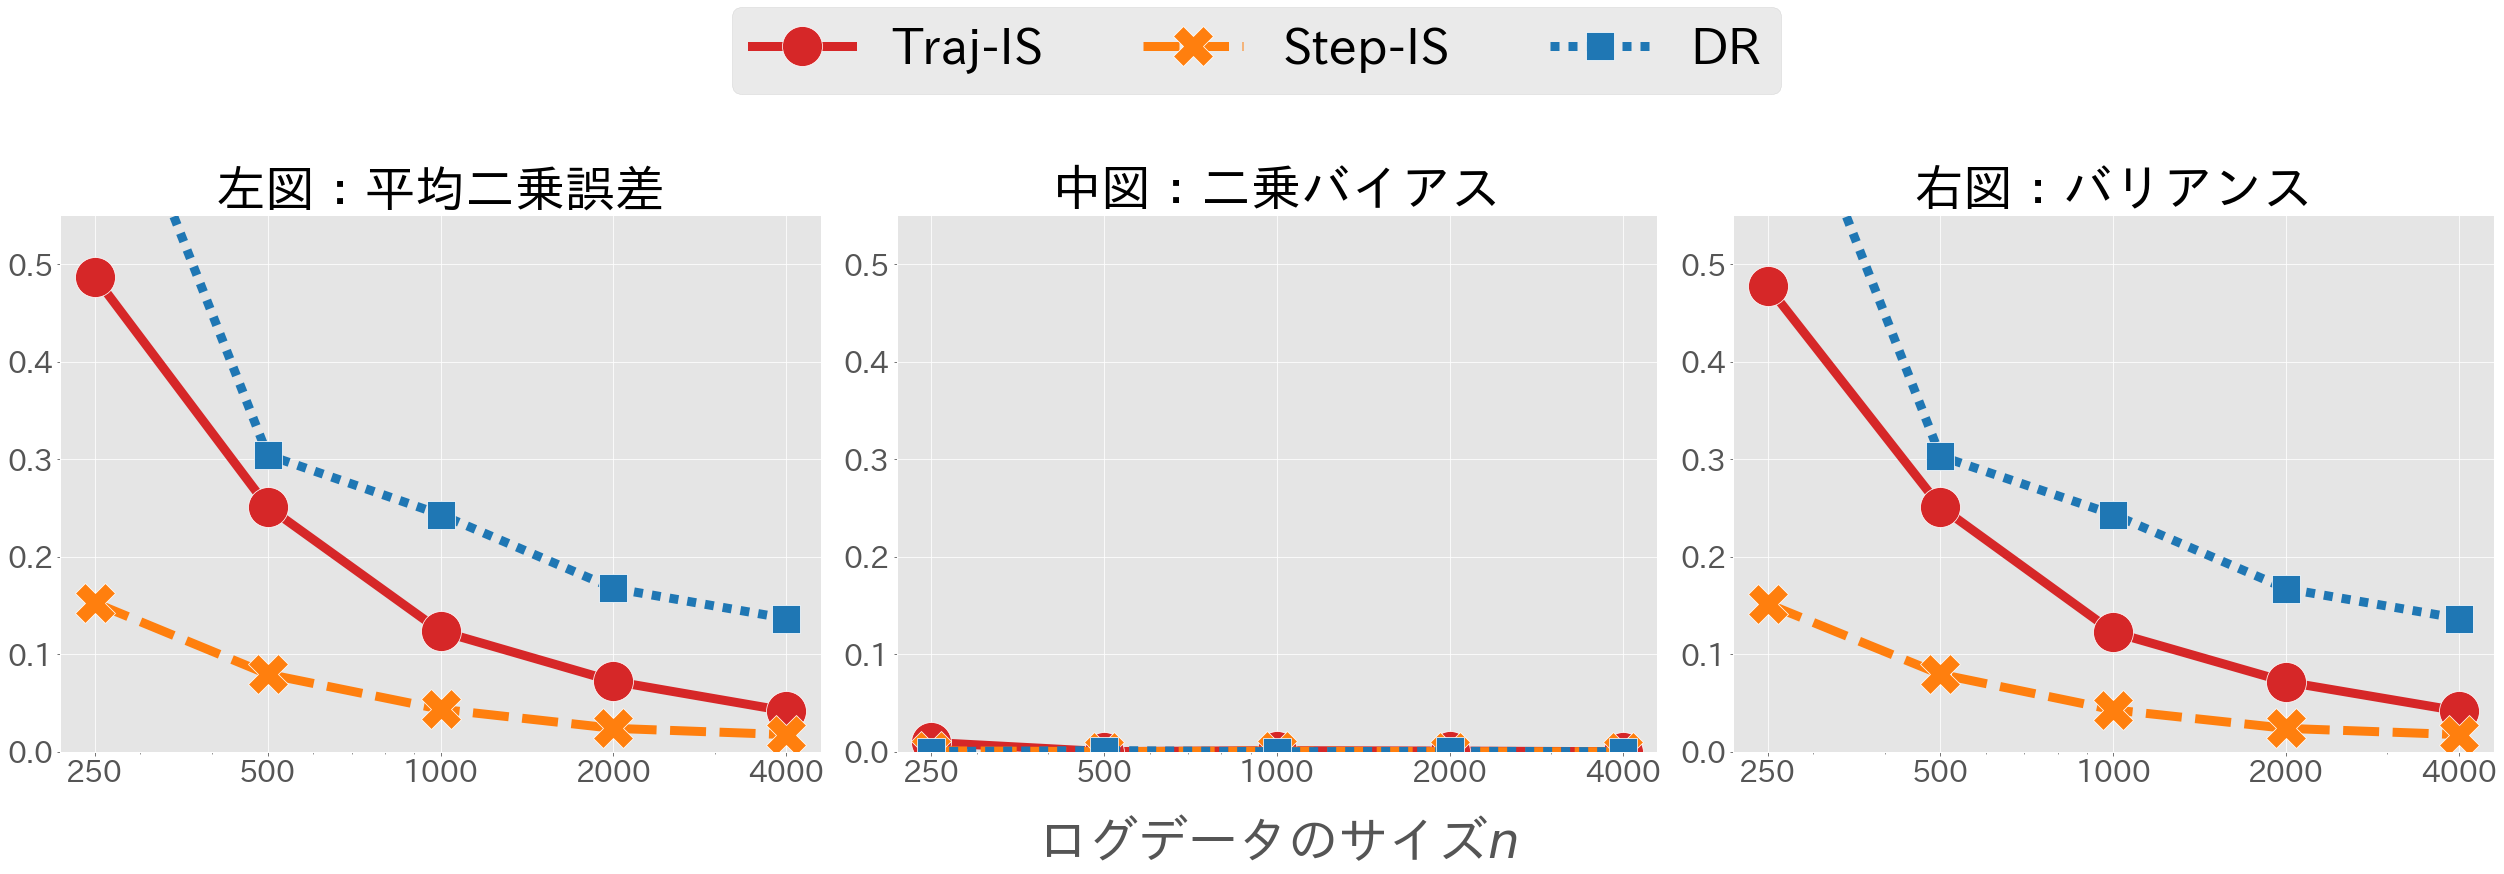

In [17]:
plt.style.use('ggplot')
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange", "tab:blue"],
        data=result_df_data.query("est == 'tis' or est == 'sis' or est == 'dr'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.55)
    ax.tick_params(axis="y", labelsize=30)
    # ax.set_yticks([0.0, 0.35, 0.7])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["Traj-IS", "Step-IS", "DR"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15),
    ncol=5, loc="center",
)


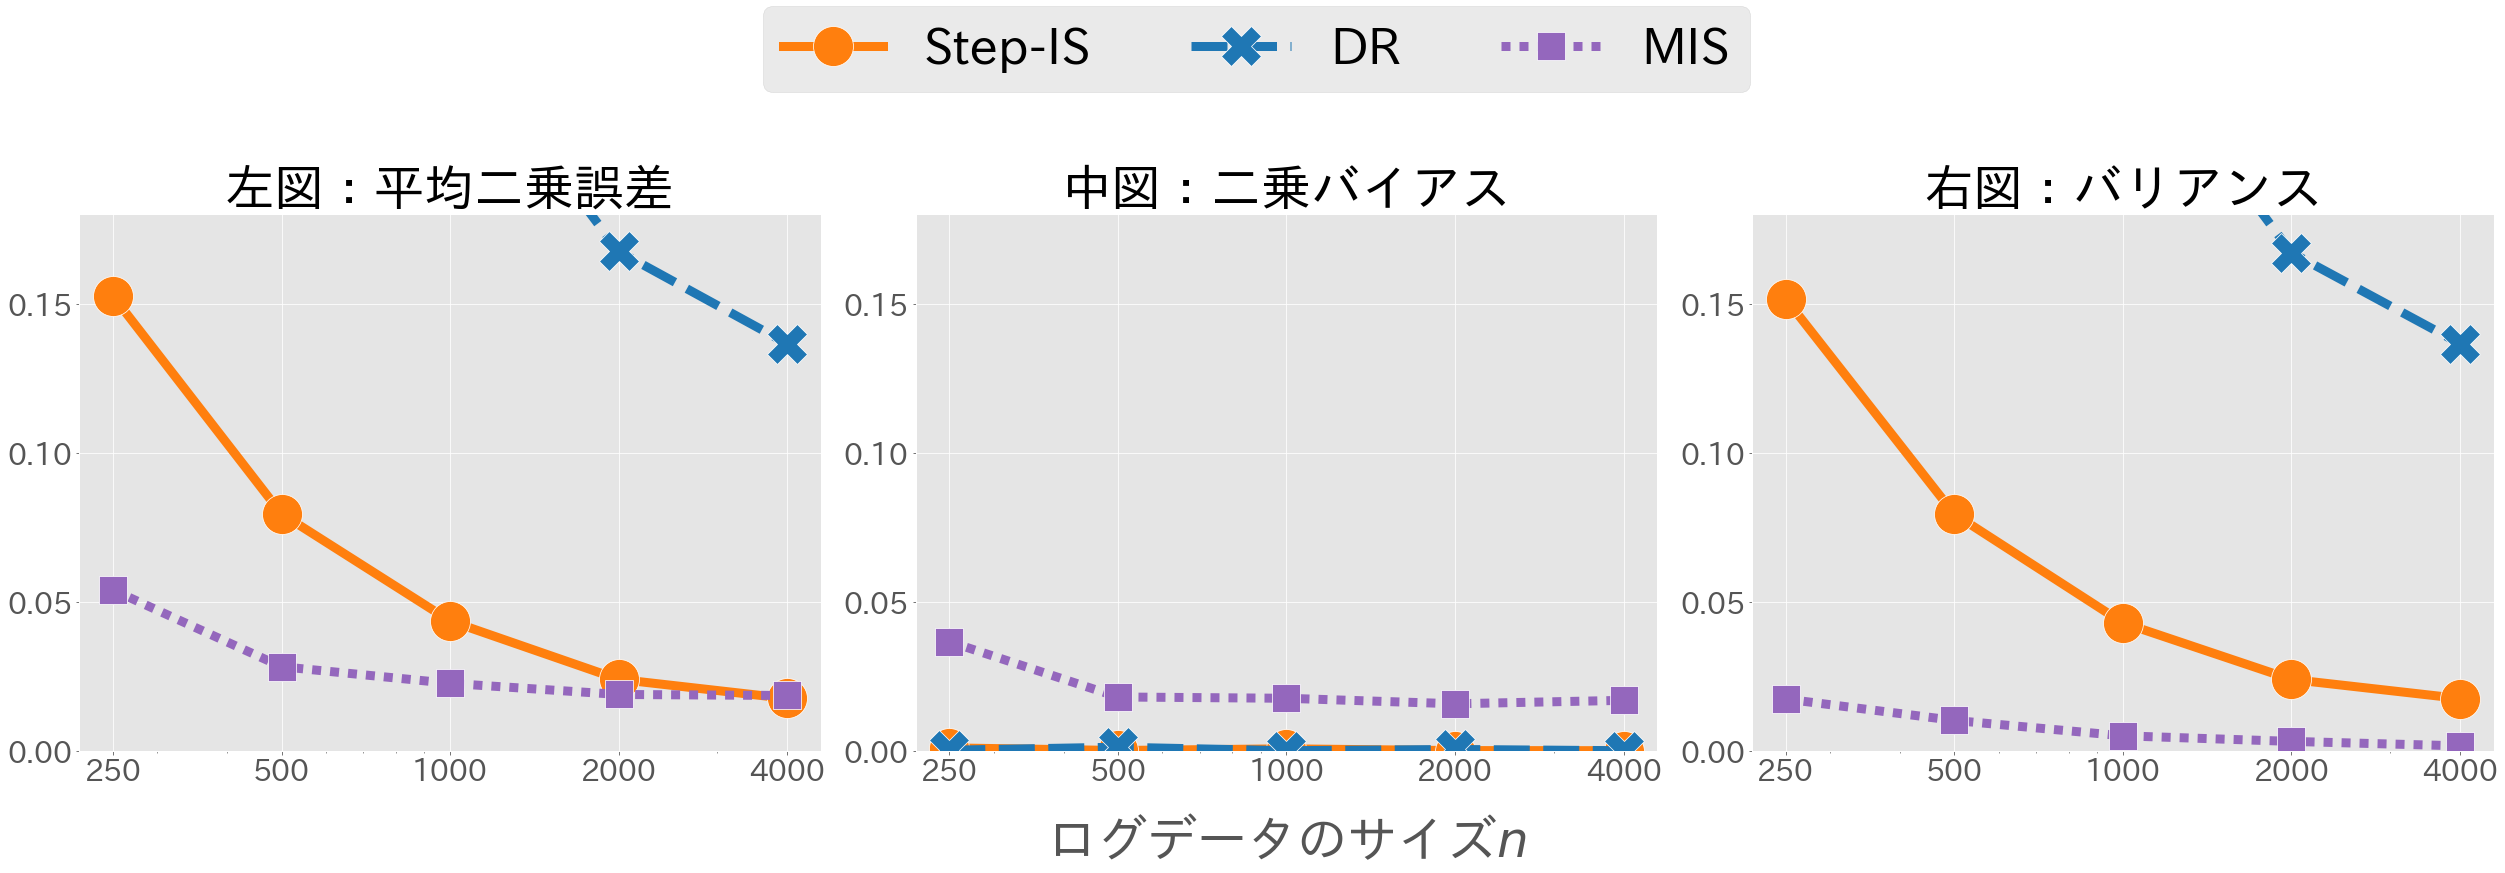

In [18]:
plt.style.use('ggplot')
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:orange", "tab:blue", "tab:purple"],
        data=result_df_data.query("est == 'sis' or est == 'dr' or est == 'mis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.18)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.05, 0.1, 0.15])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["Step-IS", "DR", "MIS"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15),
    ncol=5, loc="center",
)


## 軌跡の長さを変化させる

In [8]:
## 実験設定

num_runs = 200 # number of experiment runs
dim_state = 5 # state dimensions
num_states = 50 # number of states
num_actions = 10 # number of unique actions
num_data = 1000 # number of samples
beta = -1 # parameter of the logging policy
random_state = 12345
H_list = [4, 6, 8, 10, 12]


In [9]:
# calculate the ground-truth value of a new policy, our estimand
random_ = check_random_state(random_state)
theta = random_.normal(size=(dim_state, num_actions))
M = random_.normal(size=(dim_state, num_actions))
b = random_.normal(size=(1, num_actions))
init_dist = softmax(random_.normal(size=(1, num_states)))[0]
trans_probs = softmax(random_.normal(size=(num_states, num_states, num_actions)) / 2)
result_df_list = []
for H in H_list:
    dataset_test, policy_value = calc_true_value(
        dim_state=dim_state, num_states=num_states, num_actions=num_actions, H=H,
        theta=theta, M=M, b=b, init_dist=init_dist, trans_probs=trans_probs,
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"H={H}..."):
        ## generate synthetic logged bandit data
        dataset = generate_synthetic_data(
            num_data=num_data, dim_state=dim_state, num_states=num_states, num_actions=num_actions, H=H,
            theta=theta, M=M, b=b, init_dist=init_dist, trans_probs=trans_probs, beta=beta, random_state=_,
        )

        ## perform OPE on the logged bandit data
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_avg(dataset)
        estimated_policy_values["tis"] = calc_tis(dataset)
        estimated_policy_values["sis"] = calc_sis(dataset)
        Q_hat = dataset["q_s_a"] #+ random_.normal(size=(num_states, num_actions)) / 40
        estimated_policy_values["dr"] = calc_dr(dataset, Q_hat)
        estimated_policy_values["mis"] = calc_mis(dataset, dataset_test)
        estimated_policy_value_list.append(estimated_policy_values)

        ### calculate the MSE, squared bias, and variance of estimators
        result_df = DataFrame(estimated_policy_value_list).stack()\
            .reset_index(1).rename(columns={"level_1": "est", 0: "value"})
        result_df["H"] = H
        result_df["se"] = (result_df.value - policy_value) ** 2
        result_df["bias"] = 0
        result_df["variance"] = 0
        result_df["true_value"] = policy_value
        sample_mean = DataFrame(result_df.groupby(["est"]).mean().value).reset_index()
        for est_ in sample_mean["est"]:
            estimates = result_df.loc[result_df["est"] == est_, "value"].values
            mean_estimates = sample_mean.loc[sample_mean["est"] == est_, "value"].values
            mean_estimates = np.ones_like(estimates) * mean_estimates
            result_df.loc[result_df["est"] == est_, "bias"] = (policy_value - mean_estimates) ** 2
            result_df.loc[result_df["est"] == est_, "variance"] = (estimates - mean_estimates) ** 2
    result_df_list.append(result_df)
result_df_horizon = pd.concat(result_df_list).reset_index(level=0)


H=12...: 100%|██████████| 200/200 [02:34<00:00,  1.30it/s]


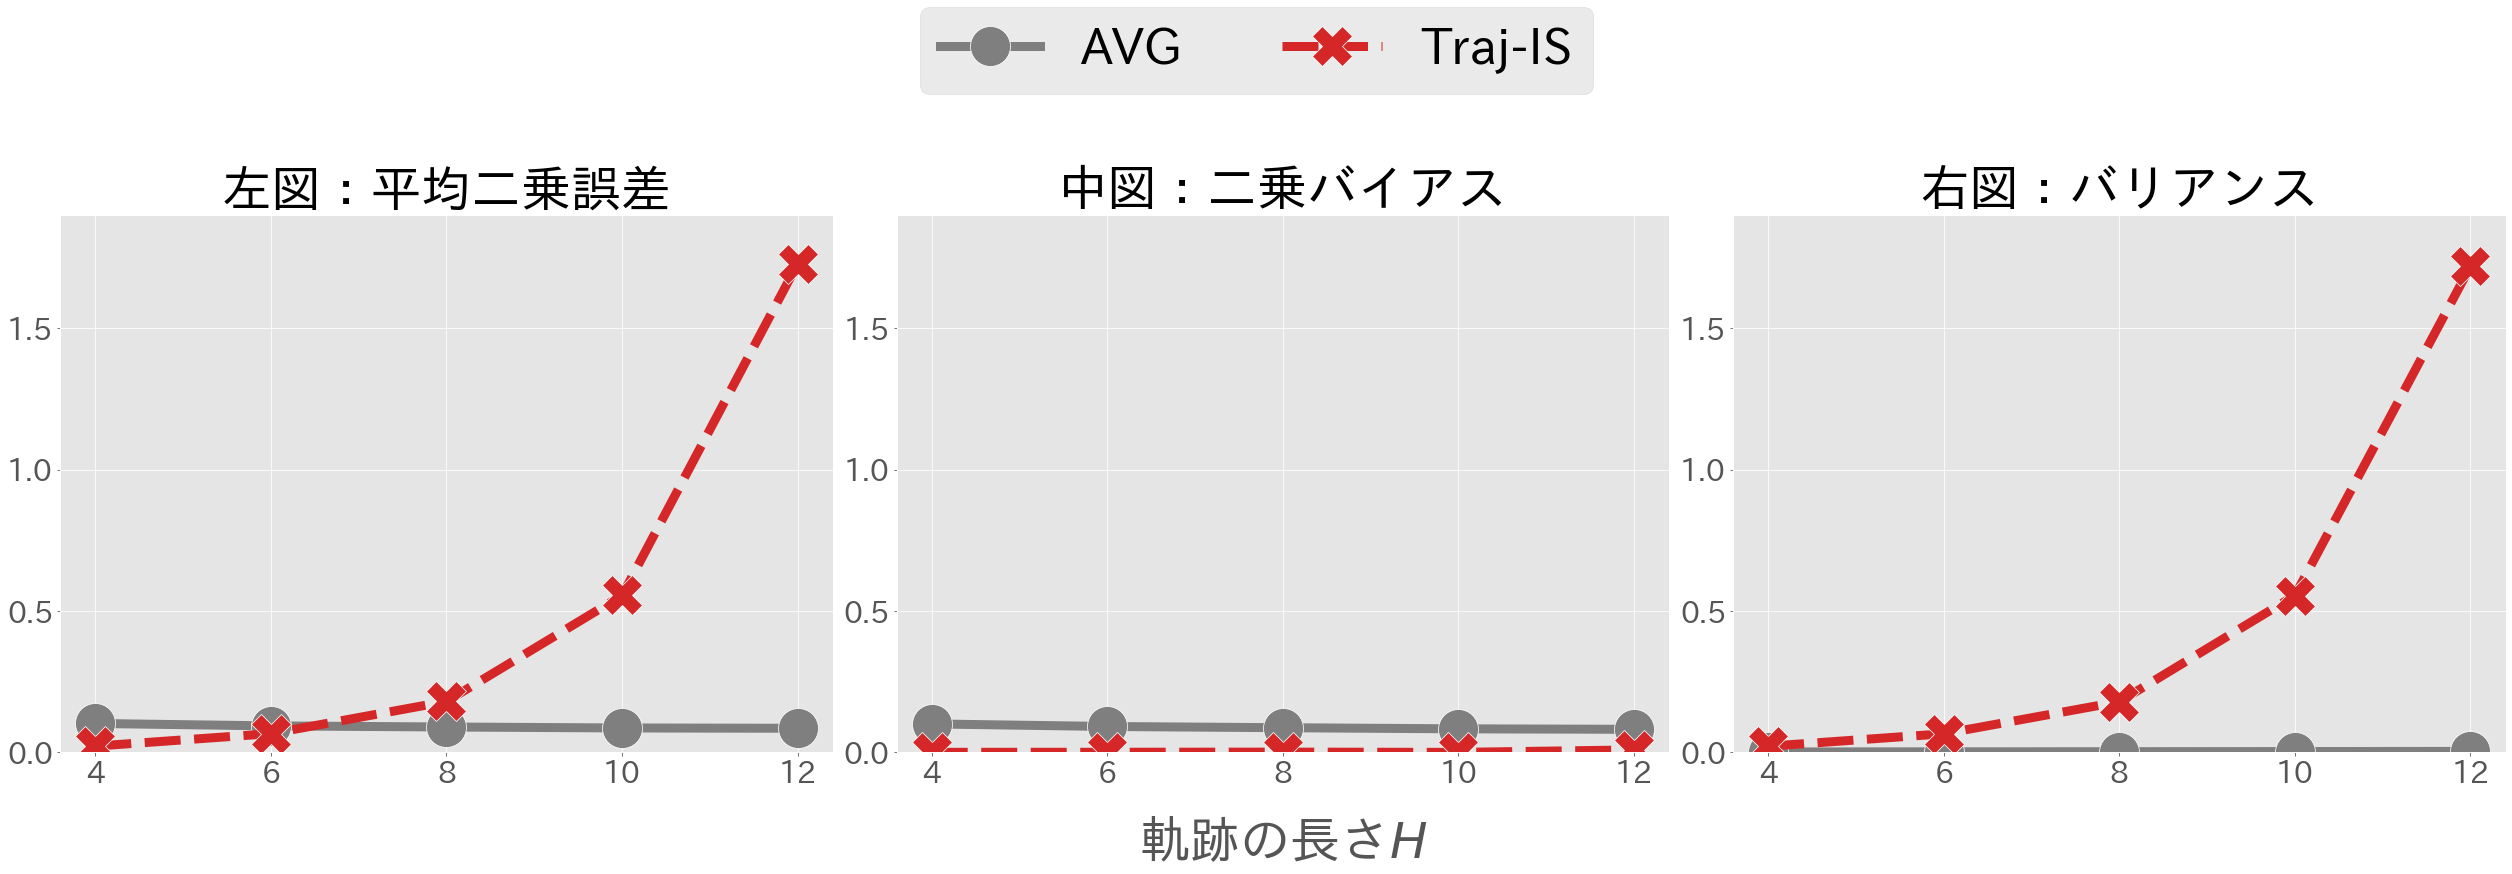

In [10]:
plt.style.use('ggplot')
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="H",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red"],
        data=result_df_horizon.query("est == 'avg' or est == 'tis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 1.9)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.5, 1.0, 1.5])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel(r"軌跡の長さ$H$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(H_list)
    ax.set_xticklabels(H_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["AVG", "Traj-IS"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15),
    ncol=5, loc="center",
)


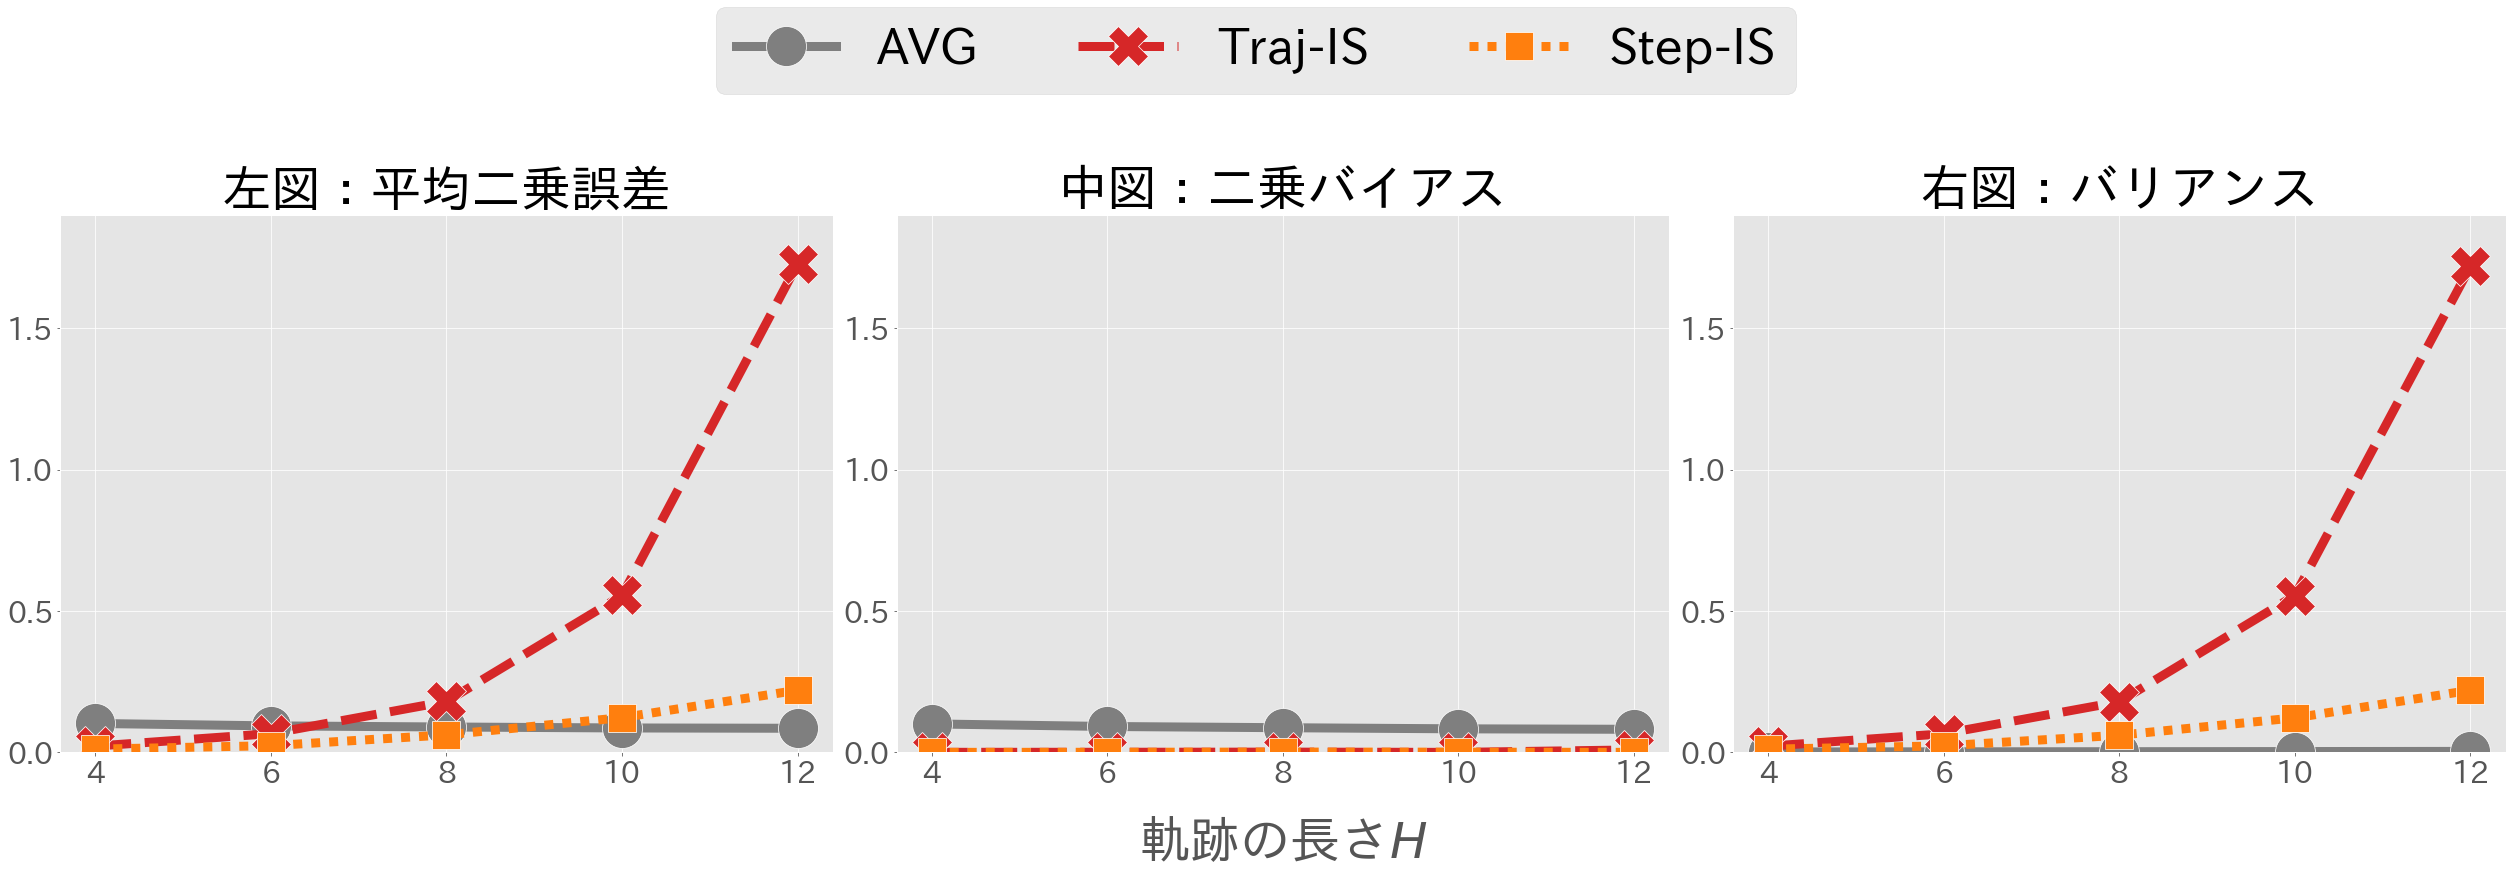

In [11]:
plt.style.use('ggplot')
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="H",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red", "tab:orange"],
        data=result_df_horizon.query("est == 'avg' or est == 'tis' or est == 'sis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 1.9)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.5, 1.0, 1.5])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel(r"軌跡の長さ$H$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(H_list)
    ax.set_xticklabels(H_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["AVG", "Traj-IS", "Step-IS"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15),
    ncol=5, loc="center",
)


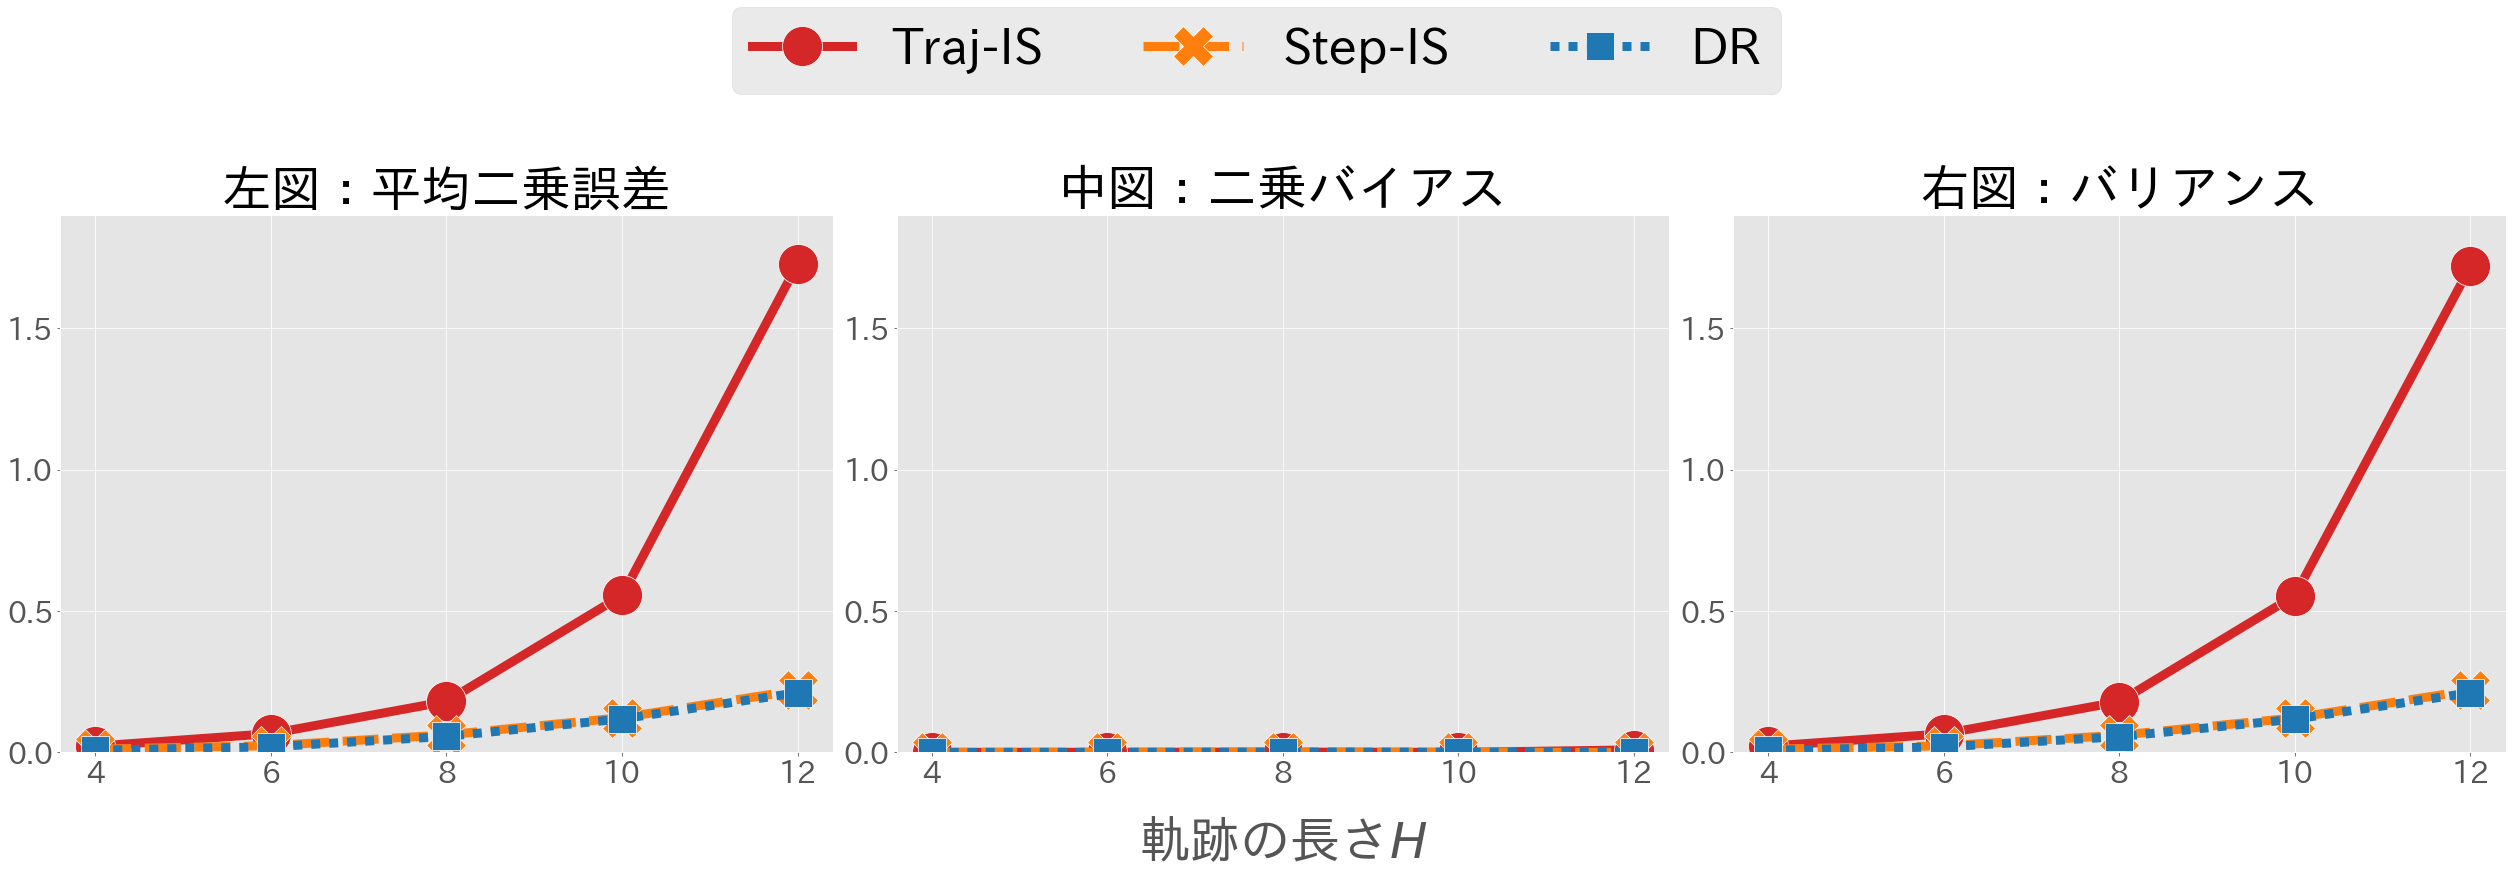

In [12]:
plt.style.use('ggplot')
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="H",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange", "tab:blue"],
        data=result_df_horizon.query("est == 'tis' or est == 'sis' or est == 'dr'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 1.9)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.5, 1.0, 1.5])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel(r"軌跡の長さ$H$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(H_list)
    ax.set_xticklabels(H_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["Traj-IS", "Step-IS", "DR"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15),
    ncol=5, loc="center",
)


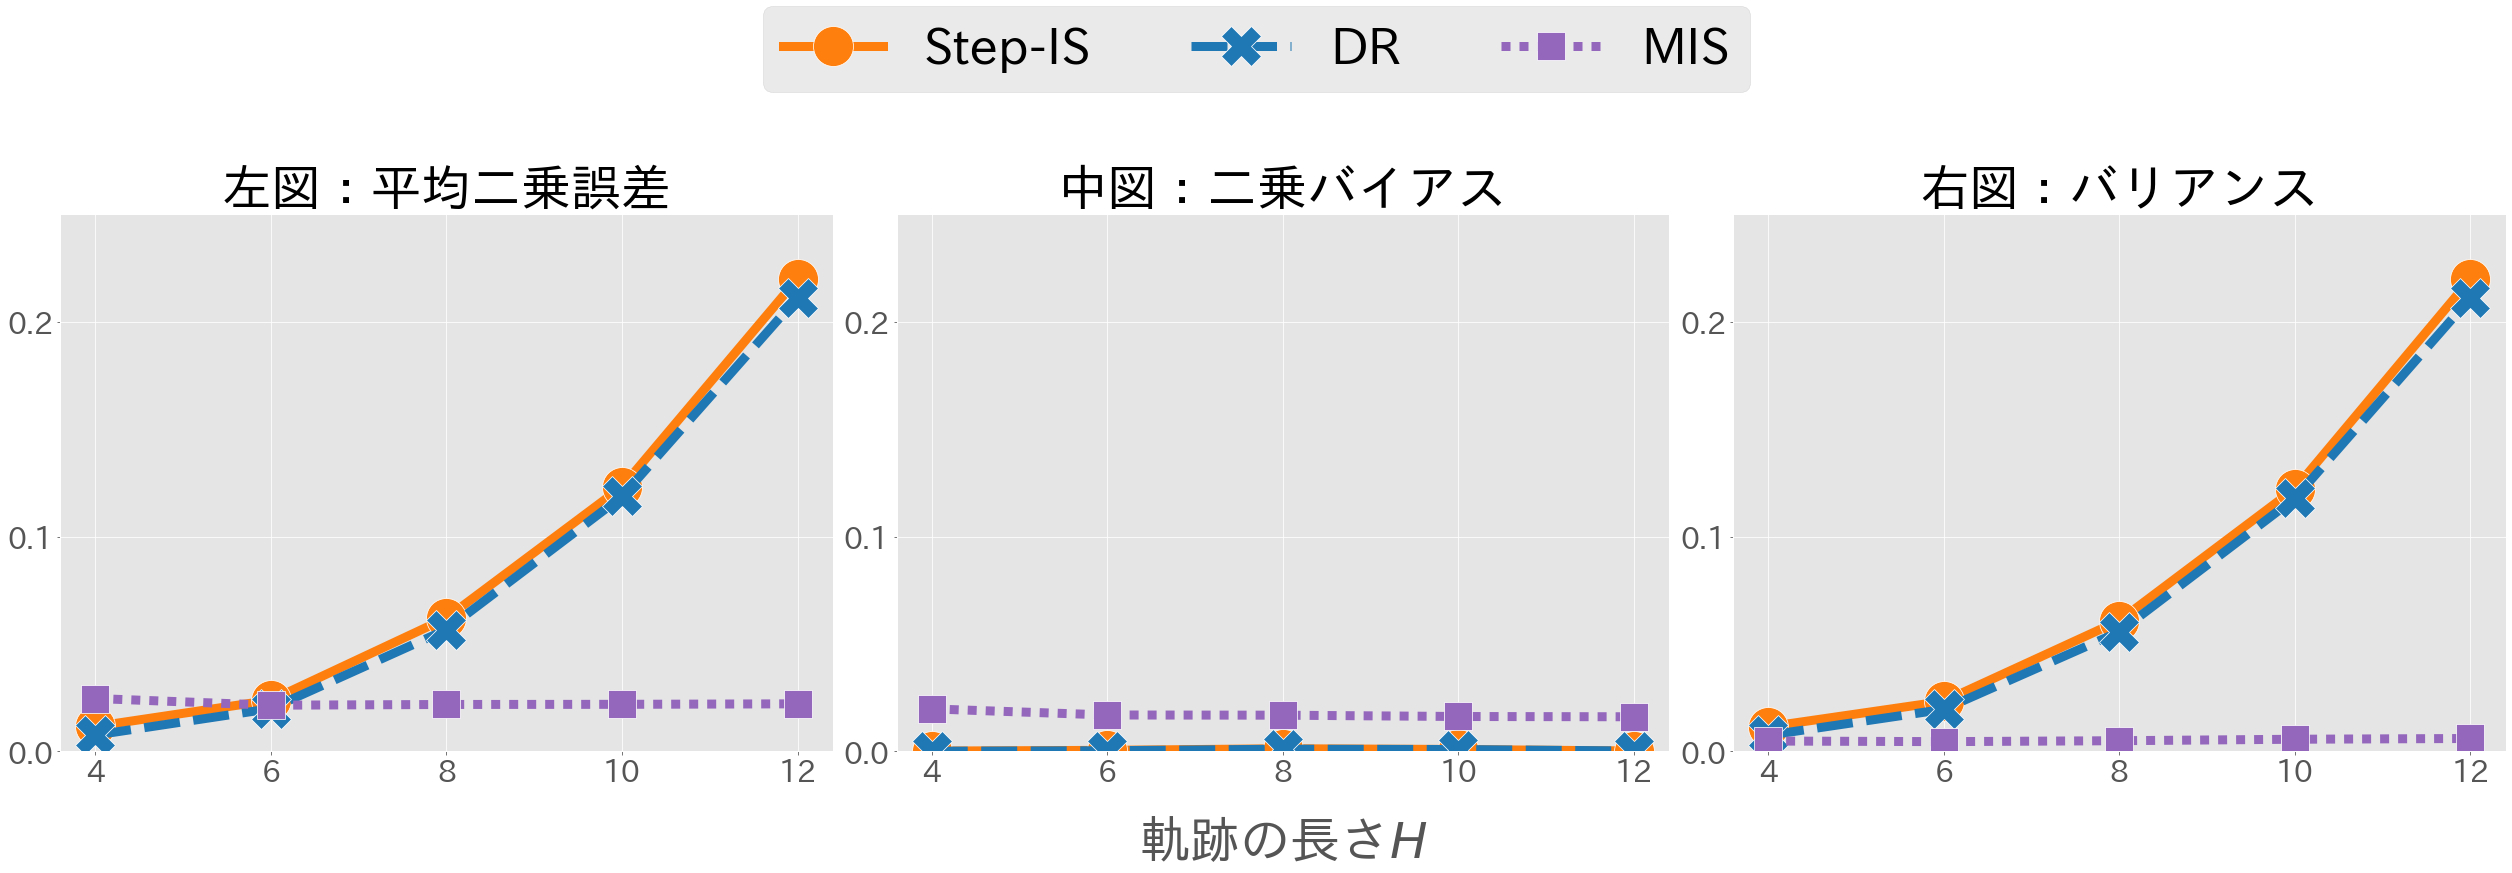

In [13]:
plt.style.use('ggplot')
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=9,
        legend=False,
        style="est",
        x="H",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:orange", "tab:blue", "tab:purple"],
        data=result_df_horizon.query("est == 'sis' or est == 'dr' or est == 'mis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.25)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.1, 0.2])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel(r"軌跡の長さ$H$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(H_list)
    ax.set_xticklabels(H_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["Step-IS", "DR", "MIS"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15),
    ncol=5, loc="center",
)


## 状態の数を変化させる

In [14]:
## 実験設定

num_runs = 200 # number of experiment runs
dim_state = 5 # state dimensions
num_actions = 10 # number of unique actions
H = 6 # length of horizon
num_data = 1000 # number of samples
beta = -1 # parameter of the logging policy
random_state = 12345
num_states_list = [10, 50, 100, 200, 500]


In [15]:
# calculate the ground-truth value of a new policy, our estimand
random_ = check_random_state(random_state)
theta = random_.normal(size=(dim_state, num_actions))
M = random_.normal(size=(dim_state, num_actions))
b = random_.normal(size=(1, num_actions))
result_df_list = []
for num_states in num_states_list:
    init_dist = softmax(random_.normal(size=(1, num_states)))[0]
    trans_probs = softmax(random_.normal(size=(num_states, num_states, num_actions)) / 2)
    dataset_test, policy_value = calc_true_value(
        dim_state=dim_state, num_states=num_states, num_actions=num_actions, H=H,
        theta=theta, M=M, b=b, init_dist=init_dist, trans_probs=trans_probs,
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_states={num_states}..."):
        ## generate synthetic logged bandit data
        dataset = generate_synthetic_data(
            num_data=num_data, dim_state=dim_state, num_states=num_states, num_actions=num_actions, H=H,
            theta=theta, M=M, b=b, init_dist=init_dist, trans_probs=trans_probs, beta=beta, random_state=_,
        )

        ## perform OPE on the logged bandit data
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_avg(dataset)
        estimated_policy_values["tis"] = calc_tis(dataset)
        estimated_policy_values["sis"] = calc_sis(dataset)
        Q_hat = dataset["q_s_a"] #+ random_.normal(size=(num_states, num_actions)) / 40
        estimated_policy_values["dr"] = calc_dr(dataset, Q_hat)
        estimated_policy_values["mis"] = calc_mis(dataset, dataset_test)
        estimated_policy_value_list.append(estimated_policy_values)

        ### calculate the MSE, squared bias, and variance of estimators
        result_df = DataFrame(estimated_policy_value_list).stack()\
            .reset_index(1).rename(columns={"level_1": "est", 0: "value"})
        result_df["num_states"] = num_states
        result_df["se"] = (result_df.value - policy_value) ** 2
        result_df["bias"] = 0
        result_df["variance"] = 0
        result_df["true_value"] = policy_value
        sample_mean = DataFrame(result_df.groupby(["est"]).mean().value).reset_index()
        for est_ in sample_mean["est"]:
            estimates = result_df.loc[result_df["est"] == est_, "value"].values
            mean_estimates = sample_mean.loc[sample_mean["est"] == est_, "value"].values
            mean_estimates = np.ones_like(estimates) * mean_estimates
            result_df.loc[result_df["est"] == est_, "bias"] = (policy_value - mean_estimates) ** 2
            result_df.loc[result_df["est"] == est_, "variance"] = (estimates - mean_estimates) ** 2
    result_df_list.append(result_df)
result_df_num_states = pd.concat(result_df_list).reset_index(level=0)


num_states=500...: 100%|██████████| 200/200 [11:25<00:00,  3.43s/it]


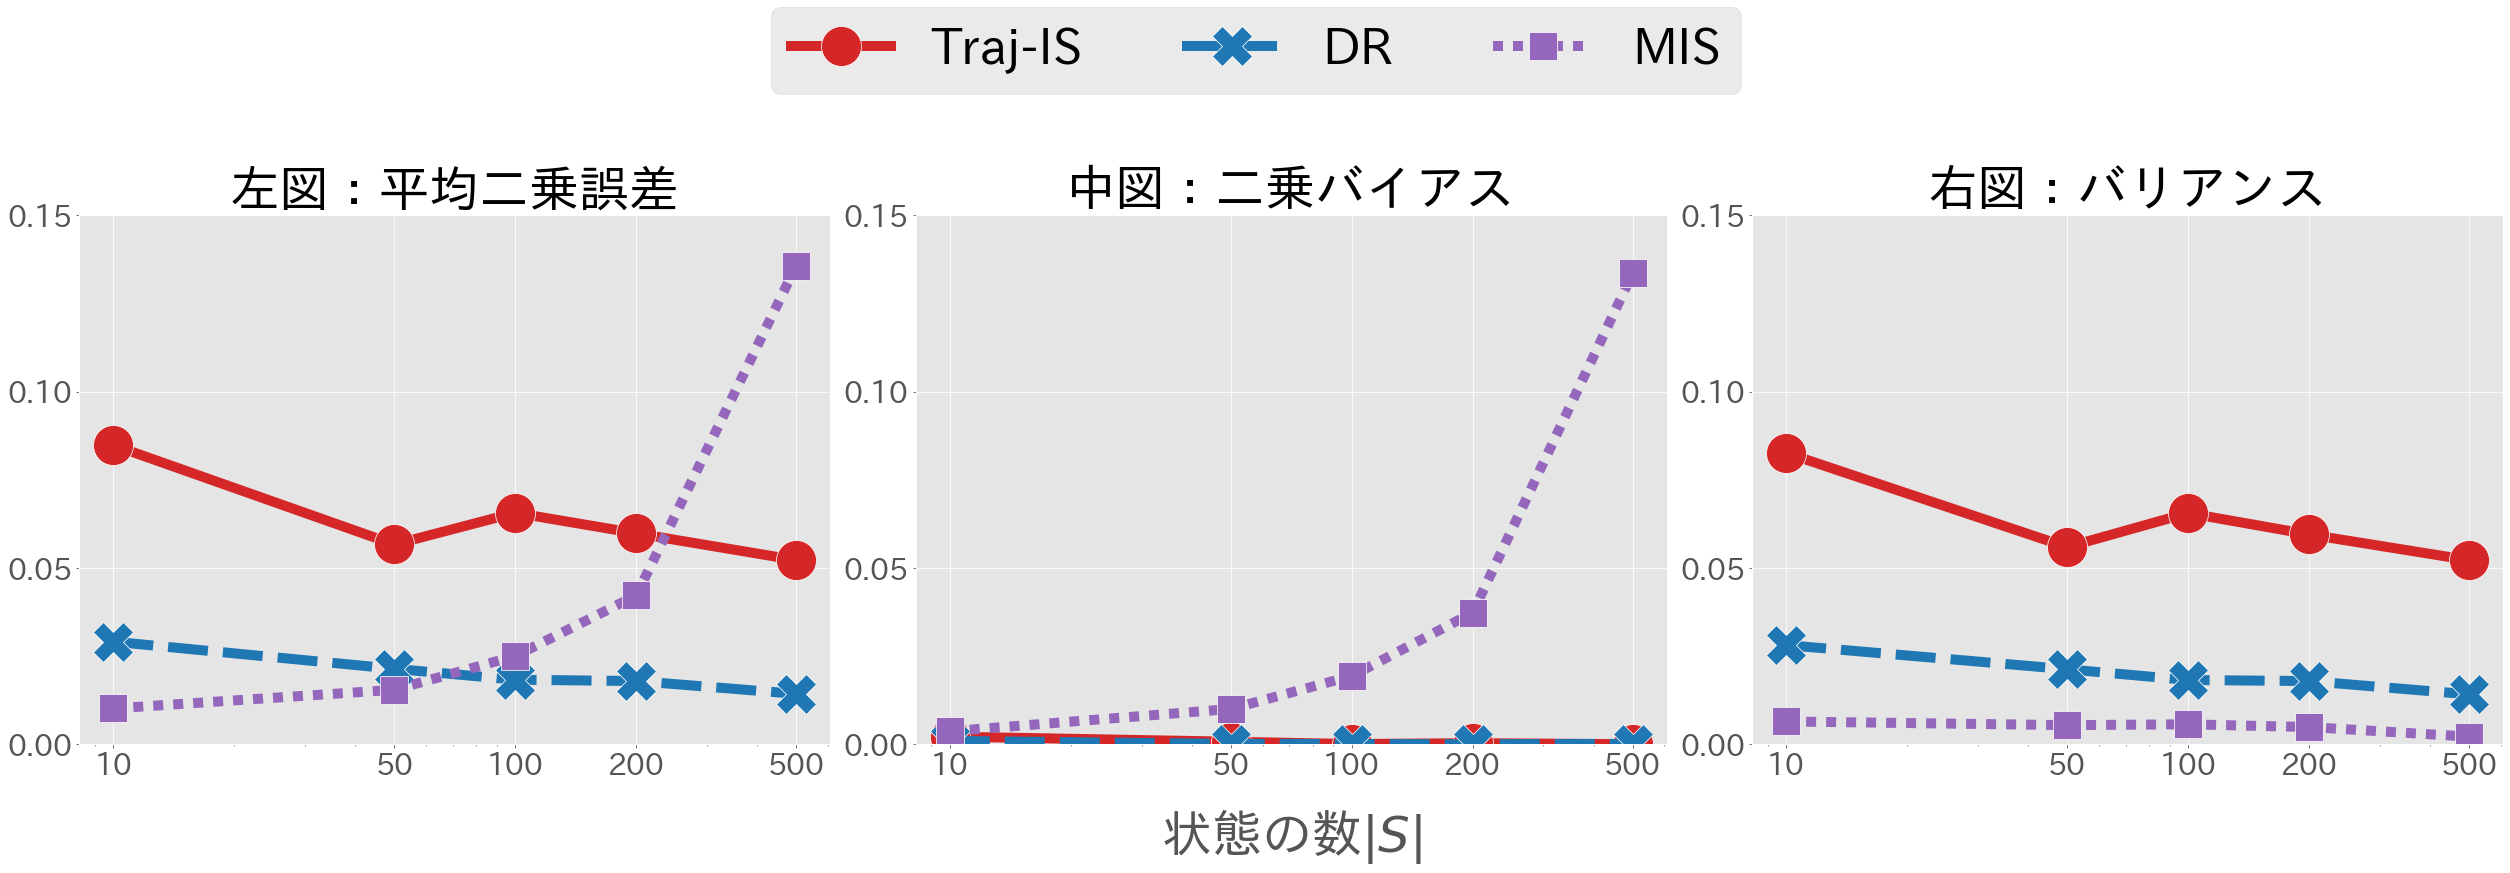

In [16]:
plt.style.use('ggplot')
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=10,
        legend=False,
        style="est",
        x="num_states",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:blue", "tab:purple"],
        data=result_df_num_states.query("est != 'avg' and est != 'sis'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.15)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.05, 0.1, 0.15])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"状態の数$|S|$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_states_list)
    ax.set_xticklabels(num_states_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["Traj-IS", "DR", "MIS"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15),
    ncol=5, loc="center",
)
